# Búsqueda Local: el mejor

Se  implementarásiguiendo  los  esquemas  de el  mejor,  y  de el  primer  mejorvecino, según se explicó en el Tema 1 de teoría, usando el operador 2-opt.Se partirá de una solución inicial aleatoria.  
Los algoritmos de búsqueda local tienen su propia condición de parada, pero adicionalmente, en prevención de tiempos excesivos en algún caso, se añadirá una condición de parada alternativa (OR) basada en el número de evaluaciones que esté realizando la búsqueda, es decir, el número de vecesque se llame al cálculo de la función de coste.   
Este valor para la Búsqueda Local será de 1600·nllamadas a la función de coste.  
La búsqueda con cada algoritmo se debe ejecutar 10 veces consemillas distintas, como en el caso de la Aleatoria.

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import *

---
## Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.
- agregar_resultados(dataframe,nombre,result): guarda los resultados de la ejecución en el dataframe según la plantilla del pdf.

In [2]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [3]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [4]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [5]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [6]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):
        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

In [7]:
def agregar_resultados(dataframe,nombre,result):

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"Coste")] = result[i][1]

    dataframe.loc["Media",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].std()

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"#Ev")] = result[i][2]

    dataframe.loc["Media",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].std()

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [8]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [9]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [10]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[548472, 162592, 914504, 704747, 883158, 518238, 468631, 607635, 686821, 466121]


## Dataframe para ver los resultados

In [11]:
mux = pd.MultiIndex.from_product([["St70","Ch130","A280","Pa654","Vm1084","Vm1748"], ['Coste','#Ev']])
resultados = pd.DataFrame(
    columns=mux,
    index = ['Ejecución 1', 'Ejecución 2', 'Ejecución 3',"Ejecución 4","Ejecución 5","Ejecución 6","Ejecución 7","Ejecución 8","Ejecución 9","Ejecución 10","Media","Des. Tip. (s)"]
)

#### st70

,Semilla,Coste,Nº de evaluaciones
0,548472.0,1343.0,112000.0
1,162592.0,1120.0,112000.0
2,914504.0,1298.0,112000.0
3,704747.0,1071.0,112000.0
4,883158.0,1144.0,112000.0
5,518238.0,1102.0,112000.0
6,468631.0,1512.0,112000.0
7,607635.0,1198.0,112000.0
8,686821.0,1237.0,112000.0
9,466121.0,1233.0,112000.0


Media coste:  1225.8
Desviación típica coste:  132.90915861762292
Media nº de evaluaciones:  112000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


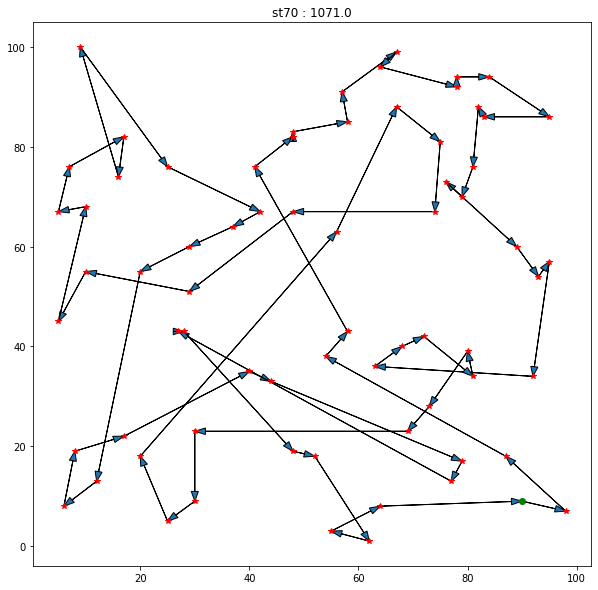

In [12]:
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
representacion_datos(result,"st70")

agregar_resultados(resultados,"St70",result)

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,548472.0,23549.0,208000.0
1,162592.0,24947.0,208000.0
2,914504.0,23166.0,208000.0
3,704747.0,24656.0,208000.0
4,883158.0,22211.0,208000.0
5,518238.0,23846.0,208000.0
6,468631.0,23937.0,208000.0
7,607635.0,24717.0,208000.0
8,686821.0,22495.0,208000.0
9,466121.0,23918.0,208000.0


Media coste:  23744.2
Desviación típica coste:  918.0782827914693
Media nº de evaluaciones:  208000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


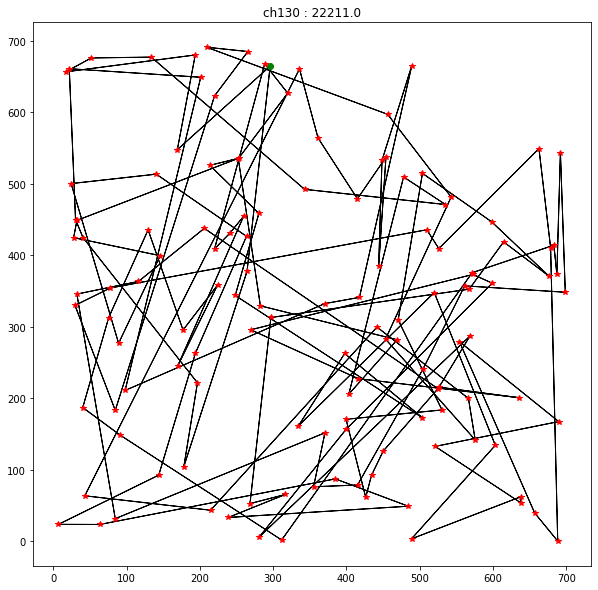

In [13]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"ch130")

agregar_resultados(resultados,"Ch130",result)

#### a280

,Semilla,Coste,Nº de evaluaciones
0,548472.0,27283.0,448000.0
1,162592.0,26558.0,448000.0
2,914504.0,25863.0,448000.0
3,704747.0,25367.0,448000.0
4,883158.0,27055.0,448000.0
5,518238.0,26820.0,448000.0
6,468631.0,27333.0,448000.0
7,607635.0,26324.0,448000.0
8,686821.0,25139.0,448000.0
9,466121.0,26400.0,448000.0


Media coste:  26414.2
Desviación típica coste:  762.299561997921
Media nº de evaluaciones:  448000.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


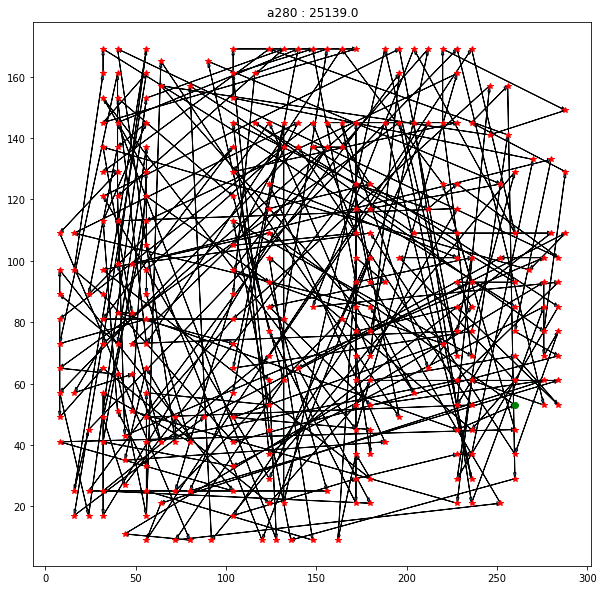

In [14]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )

representacion_datos(result,"a280")

agregar_resultados(resultados,"A280",result)

#### p654

,Semilla,Coste,Nº de evaluaciones
0,548472.0,1982334.0,1046400.0
1,162592.0,1829036.0,1046400.0
2,914504.0,1997397.0,1046400.0
3,704747.0,2025072.0,1046400.0
4,883158.0,2010331.0,1046400.0
5,518238.0,1963249.0,1046400.0
6,468631.0,1985424.0,1046400.0
7,607635.0,2015600.0,1046400.0
8,686821.0,1956213.0,1046400.0
9,466121.0,1906079.0,1046400.0


Media coste:  1967073.5
Desviación típica coste:  59615.671476643714
Media nº de evaluaciones:  1046400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


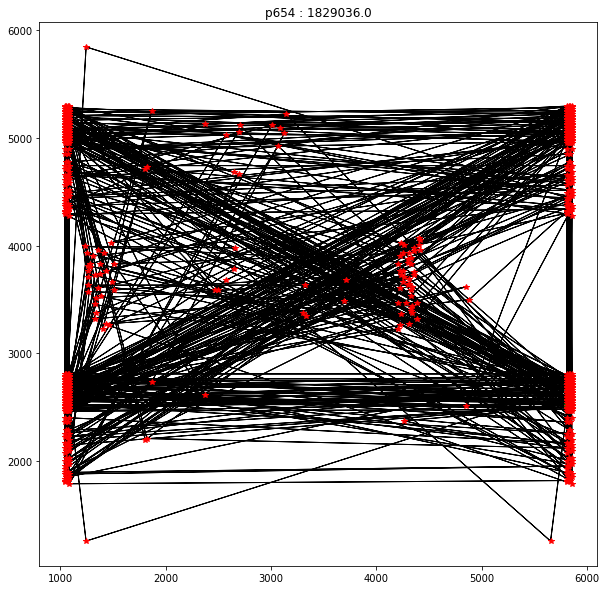

In [15]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"p654")

agregar_resultados(resultados,"Pa654",result)

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,548472.0,8322839.0,1734400.0
1,162592.0,8278559.0,1734400.0
2,914504.0,8330949.0,1734400.0
3,704747.0,8325040.0,1734400.0
4,883158.0,8551875.0,1734400.0
5,518238.0,8515591.0,1734400.0
6,468631.0,8559312.0,1734400.0
7,607635.0,8438387.0,1734400.0
8,686821.0,8527299.0,1734400.0
9,466121.0,8274081.0,1734400.0


Media coste:  8412393.2
Desviación típica coste:  117801.46411163337
Media nº de evaluaciones:  1734400.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


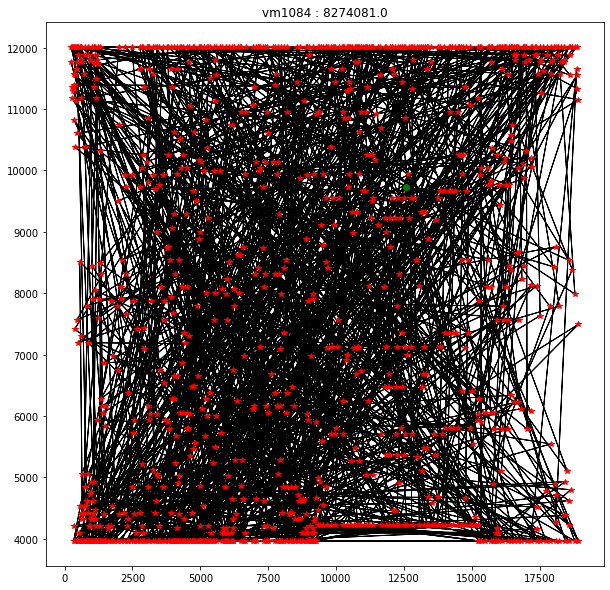

In [16]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"vm1084")

agregar_resultados(resultados,"Vm1084",result)

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,548472.0,15051918.0,2796800.0
1,162592.0,14588539.0,2796800.0
2,914504.0,14771671.0,2796800.0
3,704747.0,14940328.0,2796800.0
4,883158.0,14907335.0,2796800.0
5,518238.0,14980121.0,2796800.0
6,468631.0,14950542.0,2796800.0
7,607635.0,14615445.0,2796800.0
8,686821.0,14912724.0,2796800.0
9,466121.0,14724301.0,2796800.0


Media coste:  14844292.4
Desviación típica coste:  159227.16250843913
Media nº de evaluaciones:  2796800.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


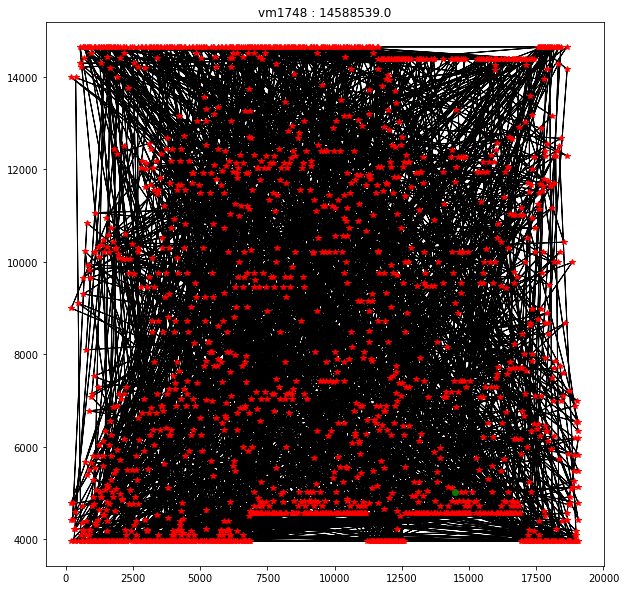

In [17]:
dataset = vm1748

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_local_el_mejor,  itertools.product(semillas,[dataset]) )
    
representacion_datos(result,"vm1748")

agregar_resultados(resultados,"Vm1748",result)

---
# Resultados

In [18]:
resultados

St70                 Ch130                  A280  \
                    Coste       #Ev       Coste       #Ev       Coste   
Ejecución 1        1343.0    112000     23549.0    208000     27283.0   
Ejecución 2        1120.0    112000     24947.0    208000     26558.0   
Ejecución 3        1298.0    112000     23166.0    208000     25863.0   
Ejecución 4        1071.0    112000     24656.0    208000     25367.0   
Ejecución 5        1144.0    112000     22211.0    208000     27055.0   
Ejecución 6        1102.0    112000     23846.0    208000     26820.0   
Ejecución 7        1512.0    112000     23937.0    208000     27333.0   
Ejecución 8        1198.0    112000     24717.0    208000     26324.0   
Ejecución 9        1237.0    112000     22495.0    208000     25139.0   
Ejecución 10       1233.0    112000     23918.0    208000     26400.0   
Media              1225.8  112000.0     23744.2  208000.0     26414.2   
Des. Tip. (s)  132.909159       0.0  918.078283       0.0  762.299562   

                                Pa654                    Vm1084             \
                    #Ev         Coste        #Ev          Coste        #Ev   
Ejecución 1      448000     1982334.0    1046400      8322839.0    1734400   
Ejecución 2      448000     1829036.0    1046400      8278559.0    1734400   
Ejecución 3      448000     1997397.0    1046400      8330949.0    1734400   
Ejecución 4      448000     2025072.0    1046400      8325040.0    1734400   
Ejecución 5      448000     2010331.0    1046400      8551875.0    1734400   
Ejecución 6      448000     1963249.0    1046400      8515591.0    1734400   
Ejecución 7      448000     1985424.0    1046400      8559312.0    1734400   
Ejecución 8      448000     2015600.0    1046400      8438387.0    1734400   
Ejecución 9      448000     1956213.0    1046400      8527299.0    1734400   
Ejecución 10     448000     1906079.0    1046400      8274081.0    1734400   
Media          448000.0     1967073.5  1046400.0      8412393.2  1734400.0   
Des. Tip. (s)       0.0  59615.671477        0.0  117801.464112        0.0   

                      Vm1748             
                       Coste        #Ev  
Ejecución 1       15051918.0    2796800  
Ejecución 2       14588539.0    2796800  
Ejecución 3       14771671.0    2796800  
Ejecución 4       14940328.0    2796800  
Ejecución 5       14907335.0    2796800  
Ejecución 6       14980121.0    2796800  
Ejecución 7       14950542.0    2796800  
Ejecución 8       14615445.0    2796800  
Ejecución 9       14912724.0    2796800  
Ejecución 10      14724301.0    2796800  
Media             14844292.4  2796800.0  
Des. Tip. (s)  159227.162508        0.0

In [19]:
resultados.to_csv(r'./Resultados.csv')